<a href="https://colab.research.google.com/github/Narusi/My-Projects/blob/master/RevolutPortfolioNewAssets%20v0.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
!pip install yfinance

In [0]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr

import requests
from bs4 import BeautifulSoup

import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=3)

In [63]:
portfolio = ['MCD', 'T', 'PFE','FB','MSFT']
candidates = ['AAPL','ABBV','ABT','AGM','AGNC','ALB','AMTD','AMZN','APD','ARR',
              'AVAL','BABA','BAH','BEN','BLK','CAH','CATY','CBT','CCBG','CCL',
              'CFG','CL','CMA','CMCSA','COST','CSCO','CVS','CVX','D','DDS',
              'DUK','DX','EBF','EMR','ENB','EPD','EPR','FDX','FITB','FRT','GIS',
              'GOOG','GS','GWB','HBAN','IBCP','IBM','IMBBY','INTC','IRM','JNJ',
              'JPM','KEY','KMB','KO','LOW','MA','MAIN','MBWM','MCY','MDP','MDT',
              'MED','MMM','MMP','MO','MSI','MSM','NFLX','NNN','NRIM','NTAP','O',
              'OC','OKE','OZK','PEBO','PEP','PFG','PG','PLD','PM','PNC','PRU',
              'RCL','RF','SBUX','SKT','SNV','SO','SPG','STAG','STI','SWM','TGT',
              'TM','TSLA','TXN','UHT','UNH','UNM','UVV','V','VZ','WBS','WELL',
              'WEN','WFC','WMT','XOM']

assets = pd.Series(portfolio + candidates).drop_duplicates().to_list()

data = yf.download(assets, period='10y').sort_index().resample('D').last()

prices = data['Adj Close'].fillna(method="ffill")
close = data['Close'].fillna(method="ffill")

print('\nCheck for duplicates!')
print(np.sort(candidates))

[*********************100%***********************]  115 of 115 completed

Check for duplicates!
['AAPL' 'ABBV' 'ABT' 'AGM' 'AGNC' 'ALB' 'AMTD' 'AMZN' 'APD' 'ARR' 'AVAL'
 'BABA' 'BAH' 'BEN' 'BLK' 'CAH' 'CATY' 'CBT' 'CCBG' 'CCL' 'CFG' 'CL' 'CMA'
 'CMCSA' 'COST' 'CSCO' 'CVS' 'CVX' 'D' 'DDS' 'DUK' 'DX' 'EBF' 'EMR' 'ENB'
 'EPD' 'EPR' 'FDX' 'FITB' 'FRT' 'GIS' 'GOOG' 'GS' 'GWB' 'HBAN' 'IBCP'
 'IBM' 'IMBBY' 'INTC' 'IRM' 'JNJ' 'JPM' 'KEY' 'KMB' 'KO' 'LOW' 'MA' 'MAIN'
 'MBWM' 'MCY' 'MDP' 'MDT' 'MED' 'MMM' 'MMP' 'MO' 'MSI' 'MSM' 'NFLX' 'NNN'
 'NRIM' 'NTAP' 'O' 'OC' 'OKE' 'OZK' 'PEBO' 'PEP' 'PFG' 'PG' 'PLD' 'PM'
 'PNC' 'PRU' 'RCL' 'RF' 'SBUX' 'SKT' 'SNV' 'SO' 'SPG' 'STAG' 'STI' 'SWM'
 'TGT' 'TM' 'TSLA' 'TXN' 'UHT' 'UNH' 'UNM' 'UVV' 'V' 'VZ' 'WBS' 'WELL'
 'WEN' 'WFC' 'WMT' 'XOM']


In [64]:
(prices.count()[prices.count() < prices.count().quantile(0.05)]/365).sort_values()

CFG     5.241096
AVAL    5.243836
BABA    5.254795
ABBV    6.967123
FB      7.594521
STAG    8.687671
dtype: float64

In [0]:
for a in prices.count()[prices.isna().sum() > 3*365].index:
    if a not in portfolio:
        prices = prices.drop(a, axis=1)

In [66]:
def momentumBuy(close, asset='Asset', chart=False, pointVal=True):
    shortBuy = close > close.rolling(50).mean()
    mediumBuy = close > close.rolling(100).mean()
    longBuy = close > close.rolling(200).mean()

    medMBuy = close.rolling(50).mean() > close.rolling(100).mean()
    longMBuy = close.rolling(50).mean() > close.rolling(200).mean()

    veryLongBuy = close.rolling(100).mean() > close.rolling(200).mean()

    buySignals = pd.DataFrame(index=close.index)

    buySignals['BuySS'] = shortBuy
    buySignals['BuySM'] = mediumBuy
    buySignals['BuySL'] = longBuy
    buySignals['BuyMM'] = medMBuy
    buySignals['BuyML'] = longMBuy
    buySignals['BuyLL'] = veryLongBuy

    ts = pd.DataFrame({asset:close.div(close.iloc[0]),
                    'Returns':np.log(close/close.shift(1)),
                    'BuySignal':buySignals.sum(axis=1)},
                    index=close.index)

    momSum = ts.groupby('BuySignal')['Returns'].sum()
    momMed = ts.groupby('BuySignal')['Returns'].median()
    buySigns = []
    holdSignal = []
    sellSign = []
    losingSignals = momSum[momSum <= 0.0].index

    for bl in range(len(buySignals.columns),0,-1):        
        if np.logical_and(momSum[bl] > 0.0, bl > max(losingSignals)):
            buySigns.append(bl)
        elif momSum[bl] > 0.0:
            holdSignal.append(bl)
        elif momMed[bl] <= 0.0:
            sellSign.append(bl)

    ts['Signal'] = ''
    ts.loc[ts[ts['BuySignal'] == 0].index, 'Signal'] = 'SELL'
    
    if len(buySigns) > 1:
        for buy in buySigns:
            ts.loc[ts[ts['BuySignal'] == buy].index, 'Signal'] = 'BUY'
    elif len(buySigns) == 1:
        ts.loc[ts[ts['BuySignal'] == buySigns[0]].index, 'Signal'] = 'BUY'
        
    if len(holdSignal) > 1:
        for hold in holdSignal:
            ts.loc[ts[ts['BuySignal'] == hold].index, 'Signal'] = 'HOLD'
    elif len(holdSignal) == 1:
        ts.loc[ts[ts['BuySignal'] == holdSignal[0]].index, 'Signal'] = 'HOLD'

    if len(sellSign) > 1:
        for sell in sellSign:
            ts.loc[ts[ts['BuySignal'] == sell].index, 'Signal'] = 'SELL'
    elif len(sellSign) == 1:
        ts.loc[ts[ts['BuySignal'] == sellSign[0]].index, 'Signal'] = 'SELL'

    for b in buySignals.columns:    
        rets = ts['Returns'][buySignals[b]]
        prob = rets[rets > 0.0].count()/rets.count()    
        #print(b, prob, rets.mean())

        ts[b] = 0
        ts.loc[buySignals[buySignals[b]].index, b] = 1

    if chart:
        ts['2018':][[asset,'BuySignal']].plot(figsize=(16,8))
        plt.show();

    #print(ts.groupby('BuySignal')['Returns'].mean())
    
    for i in range(6):
        minpick = ts.loc[ts[ts['BuySignal'] >= i].index]
        probs = minpick.groupby('BuySignal')['Returns'].count()/minpick['Returns'].count()    
        rets = minpick.groupby('BuySignal')['Returns'].mean()
        std = minpick.groupby('BuySignal')['Returns'].std()

        dprobs = minpick[minpick['Returns'] < 0.0].groupby('BuySignal')['Returns'].count()/minpick.groupby('BuySignal')['Returns'].count()
        #print((probs * rets).sum())
        #print(dprobs)

    ts['LAG.7'] = ts['Returns'].shift(7).rolling(7).sum()
    ts['LAG.14'] = ts['Returns'].shift(14).rolling(14).sum()
    ts['LAG.28'] = ts['Returns'].shift(28).rolling(28).sum()
    ts['LAG.90'] = ts['Returns'].shift(90).rolling(90).sum()

    for ss in buySignals.columns:
        rets = ts[ts[ss] == 1][['LAG.7','LAG.14','LAG.28','LAG.90']].dropna()
        prob = rets[rets > 0.01].count()/rets.count()
        hrets = rets[rets > 0.01].mean()

        #print('\n',ss)
        #print(rets.mean(), '\n',rets.median())
        #print('\nProbabilities:')
        #print(prob.mean())
        #print(prob * hrets)
    #print(ts.groupby('Signal')['Returns'].mean())

    if pointVal:
        return ts.iloc[-1]['Signal']
    else:
        return ts

#testPrices = yf.download('CSCO')['Close']
#timeSeries = momentumBuy(testPrices, asset='CSCO')
#print(timeSeries.groupby(['Signal','BuySignal'])['Returns'].mean())
#timeSeries.tail()
momentumBuy(testPrices, asset='CSCO', pointVal=True)

'HOLD'

In [67]:
mret = prices.pct_change(28)
mret['Portfolio'] = mret[portfolio].mean(axis=1)
mret['Portfolio'].describe()

count    3623.000000
mean        0.013081
std         0.031159
min        -0.098438
25%        -0.004596
50%         0.015398
75%         0.031583
max         0.152812
Name: Portfolio, dtype: float64

In [68]:
profiles = pd.DataFrame(columns=list(['Name', 'Industry', 'Sub-Industry']), 
                        index=prices.columns, dtype=str)
profiles['Beta'] = 0.0
profiles['RET'] = mret[profiles.index].mean().mul(12)
profiles['STD'] = mret[profiles.index].std().mul(np.sqrt(12))

for a in prices.columns:
    try:
        profile_page = requests.get('https://finance.yahoo.com/quote/' + str(a) + '/profile?p=' + str(a))
        soup = BeautifulSoup(profile_page.content, 'html.parser')

        #print(a)

        profiles.loc[a, 'Name'] = soup.find('h3', {'class':"Fz(m) Mb(10px)"}).text

        assetVariance = np.var(mret[a])
        profiles.loc[a, 'Beta'] = (np.cov(mret['Portfolio'],mret[a])/assetVariance)[0][1]

        for span in soup.find_all('span', {'class':'Fw(600)'}):
            if str(span).find('data-reactid="21"') > 0: 
                if len(span.text) > 3: profiles.loc[a, 'Industry'] = span.text
            elif str(span).find('data-reactid="22"') > 0:
                if len(span.text) > 3: profiles.loc[a, 'Industry'] = span.text
            elif str(span).find('data-reactid="23"') > 0:
                if len(span.text) > 3: profiles.loc[a, 'Industry'] = span.text
        
            if str(span).find('data-reactid="25"') > 0:
                if len(span.text)>3:profiles.loc[a, 'Sub-Industry'] = span.text
            elif str(span).find('data-reactid="26"') > 0:
                if len(span.text)>3:profiles.loc[a, 'Sub-Industry'] = span.text
            elif str(span).find('data-reactid="27"') > 0:
                if len(span.text)>3:profiles.loc[a, 'Sub-Industry'] = span.text
    except:
        print(a)
        profiles = profiles.drop(a)
        prices = prices.drop(a, axis=1)
profiles.info()

STI
<class 'pandas.core.frame.DataFrame'>
Index: 110 entries, AAPL to XOM
Data columns (total 6 columns):
Name            110 non-null object
Industry        110 non-null object
Sub-Industry    110 non-null object
Beta            0 non-null float64
RET             110 non-null float64
STD             110 non-null float64
dtypes: float64(3), object(3)
memory usage: 11.0+ KB


In [69]:
profiles['MoM'] = prices[profiles.index].apply(momentumBuy)
profiles.loc[portfolio]

,Name,Industry,Sub-Industry,Beta,RET,STD,MoM
MCD,McDonald's Corporation,Consumer Cyclical,Restaurants,NaN,0.142383,0.126505,SELL
T,AT&T Inc.,Communication Services,Telecom Services,NaN,0.091567,0.149272,BUY
PFE,Pfizer Inc.,Healthcare,Drug Manufacturers—General,NaN,0.114286,0.160430,BUY
FB,"Facebook, Inc.",Communication Services,Internet Content & Information,NaN,0.289935,0.337909,BUY
MSFT,Microsoft Corporation,Technology,Software—Infrastructure,NaN,0.188972,0.187763,BUY


In [0]:
ret = prices.pct_change().dropna()
wret = prices.asfreq(freq='W', method='ffill').pct_change().dropna()
wretRoll = prices.pct_change(7).dropna()

log_ret = np.log(prices.div(prices.shift(1))).fillna(0.0)
alog_ret = log_ret.rolling(365).sum()

ret['Portfolio'] = ret[portfolio].mean(axis=1)
log_ret['Portfolio'] = log_ret[portfolio].mean(axis=1).fillna(0.0)

In [72]:
profiles.loc[mret[mret['Portfolio'] < 0.0].corr()['Portfolio'].sort_values().head(10).index]

,Name,Industry,Sub-Industry,Beta,RET,STD,MoM
NRIM,"Northrim BanCorp, Inc.",Financial Services,Banks—Regional,NaN,0.124659,0.214660,BUY
MED,"Medifast, Inc.",Consumer Cyclical,Personal Services,NaN,0.204026,0.434087,SELL
BAH,Booz Allen Hamilton Holding Corporation,Industrials,Consulting Services,NaN,0.225515,0.244411,BUY
TSLA,"Tesla, Inc.",Consumer Cyclical,Auto Manufacturers,NaN,0.402451,0.519972,BUY
SWM,"Schweitzer-Mauduit International, Inc.",Basic Materials,Paper & Paper Products,NaN,0.096942,0.300329,BUY
NFLX,"Netflix, Inc.",Communication Services,Entertainment,NaN,0.489349,0.553211,SELL
TGT,Target Corporation,Consumer Defensive,Discount Stores,NaN,0.140622,0.234186,BUY
SO,The Southern Company,Utilities,Utilities—Regulated Electric,NaN,0.110218,0.122370,BUY
IMBBY,Imperial Brands PLC,Consumer Defensive,Tobacco,NaN,0.066108,0.197760,HOLD
MBWM,Mercantile Bank Corporation,Financial Services,Banks—Regional,NaN,0.308521,0.344083,BUY


In [90]:
profiles[profiles['MoM'] == 'BUY'].sort_values(by='RET', ascending=False)

,Name,Industry,Sub-Industry,Beta,RET,STD,MoM,LOGRET,LOGSTD
TSLA,"Tesla, Inc.",Consumer Cyclical,Auto Manufacturers,NaN,0.402451,0.519972,BUY,0.282728,0.498615
MBWM,Mercantile Bank Corporation,Financial Services,Banks—Regional,NaN,0.308521,0.344083,BUY,0.280606,0.332967
IBCP,Independent Bank Corporation,Financial Services,Banks—Regional,NaN,0.298444,0.662447,BUY,0.127926,0.555354
FB,"Facebook, Inc.",Communication Services,Internet Content & Information,NaN,0.289935,0.337909,BUY,0.168409,0.312178
MA,Mastercard Incorporated,Financial Services,Credit Services,NaN,0.262319,0.197555,BUY,0.262100,0.252644
...,...,...,...,...,...,...,...,...,...
CCL,Carnival Corporation & Plc,Consumer Cyclical,Travel Services,NaN,0.083971,0.230303,BUY,0.065457,0.267665
GIS,"General Mills, Inc.",Consumer Defensive,Packaged Foods,NaN,0.080785,0.151276,BUY,0.077677,0.172195
GS,"The Goldman Sachs Group, Inc.",Financial Services,Capital Markets,NaN,0.069602,0.249201,BUY,0.046774,0.261426
DX,"Dynex Capital, Inc.",Real Estate,REIT—Mortgage,NaN,0.010025,0.159039,BUY,-0.000118,0.189652


In [73]:
portfolio_ind = profiles.loc[portfolio].groupby('Industry').count()['Name']
portfolio_subind = profiles.loc[portfolio].groupby('Sub-Industry').count()['Name']

print(portfolio_subind)
selection = profiles
industryCount = len(profiles.groupby('Industry').count().index)
subIndustryCount = len(profiles.groupby('Sub-Industry').count().index)

port_Ind_fully_invested = len(portfolio_ind.index) == industryCount
port_subInd_fully_invested = len(portfolio_subind.index) == subIndustryCount

for i in portfolio_ind.index:
    if port_Ind_fully_invested:
        if portfolio_ind.loc[i] == portfolio_ind.min():
            selection = selection[selection['Industry'] == i]
        else:
            selection = selection[selection['Industry'] != i]
    else:
        selection = selection[selection['Industry'] != i]
for i in portfolio_subind.index:
    if port_subInd_fully_invested:
        if portfolio_subind.loc[i] == portfolio_subind.min():
            selection = selection[selection['Industry'] == i]
        else:
            selection = selection[selection['Industry'] != i]
    else:
        selection = selection[selection['Sub-Industry'] != i]

selection.sort_values(by=['Industry', 'Sub-Industry','Beta'])

Sub-Industry
Drug Manufacturers—General        1
Internet Content & Information    1
Restaurants                       1
Software—Infrastructure           1
Telecom Services                  1
Name: Name, dtype: int64


,Name,Industry,Sub-Industry,Beta,RET,STD,MoM
APD,"Air Products and Chemicals, Inc.",Basic Materials,Chemicals,NaN,0.146963,0.179118,BUY
SWM,"Schweitzer-Mauduit International, Inc.",Basic Materials,Paper & Paper Products,NaN,0.096942,0.300329,BUY
ALB,Albemarle Corporation,Basic Materials,Specialty Chemicals,NaN,0.108573,0.289401,SELL
CBT,Cabot Corporation,Basic Materials,Specialty Chemicals,NaN,0.116055,0.291182,BUY
KO,The Coca-Cola Company,Consumer Defensive,Beverages—Non-Alcoholic,NaN,0.102390,0.120777,BUY
...,...,...,...,...,...,...,...
SPG,"Simon Property Group, Inc.",Real Estate,REIT—Retail,NaN,0.112738,0.172929,SELL
IRM,Iron Mountain Incorporated,Real Estate,REIT—Specialty,NaN,0.125723,0.244040,HOLD
D,"Dominion Energy, Inc.",Utilities,Utilities—Diversified,NaN,0.114952,0.130546,BUY
DUK,Duke Energy Corporation,Utilities,Utilities—Regulated Electric,NaN,0.095603,0.132675,HOLD


In [74]:
profiles.loc[['AMZN','TSLA','IBM','CSCO']]

,Name,Industry,Sub-Industry,Beta,RET,STD,MoM
AMZN,"Amazon.com, Inc.",Consumer Cyclical,Internet Retail,NaN,0.278548,0.273092,SELL
TSLA,"Tesla, Inc.",Consumer Cyclical,Auto Manufacturers,NaN,0.402451,0.519972,BUY
IBM,International Business Machines Corporation,Technology,Information Technology Services,NaN,0.046999,0.177815,HOLD
CSCO,"Cisco Systems, Inc.",Technology,Communication Equipment,NaN,0.107053,0.228903,HOLD


In [75]:
val = prices[selection.index].iloc[-1]/prices[selection.index].iloc[-365:].mean()
val = val[val < 1.0]
underVal = []

for a in val.index.to_list():
    if np.logical_and(prices[a].iloc[-3*365:].pct_change().mean() > 0.0,
                      a not in portfolio):
        underVal.append(a)

print('Currently assets under consideration:\n{}'.format(underVal))

Currently assets under consideration:
['EPR', 'FRT', 'MCY', 'MMM', 'NNN', 'WELL']


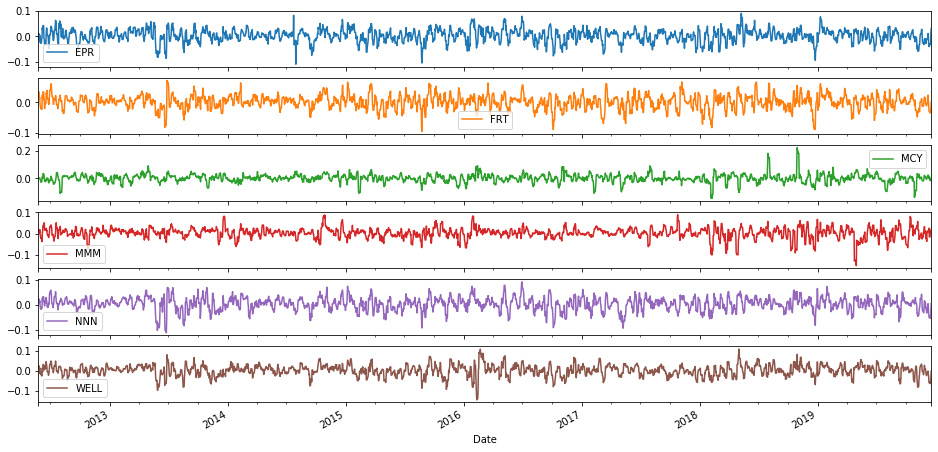

,EPR,FRT,MCY,MMM,NNN,WELL
count,2765.000000,2765.000000,2765.000000,2765.000000,2765.000000,2765.000000
mean,0.143159,0.081287,0.090458,0.134906,0.152706,0.116474
std,1.297468,1.184354,1.620685,1.314068,1.390644,1.443008
min,-5.663063,-4.882896,-7.678486,-7.835125,-5.833869,-7.572820
25%,-0.604404,-0.564148,-0.671620,-0.432459,-0.600192,-0.662972
50%,0.254752,0.177921,0.143282,0.199022,0.255669,0.201495
75%,0.991396,0.787467,0.891153,0.863228,1.031097,1.005783
max,4.722162,3.729334,11.796395,4.624184,4.751222,5.698069


In [76]:
wretRoll[underVal].plot(subplots=True, figsize=(16,8))
plt.show();

wretRoll[underVal].mul(52).describe()

Lowest correlating assets:
                              Name            Industry  ...       STD   MoM
AGNC         AGNC Investment Corp.         Real Estate  ...  0.150436   BUY
DDS                Dillard's, Inc.   Consumer Cyclical  ...  0.394513   BUY
IBCP  Independent Bank Corporation  Financial Services  ...  0.662447   BUY
MED                 Medifast, Inc.   Consumer Cyclical  ...  0.434087  SELL
SO            The Southern Company           Utilities  ...  0.122370   BUY
UVV          Universal Corporation  Consumer Defensive  ...  0.263433  HOLD

[6 rows x 7 columns]


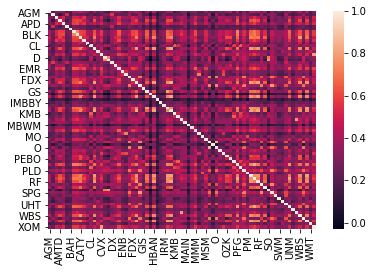

In [77]:
selAss = selection.index.to_list()
low_corr = ret.corr()[ret.corr()['Portfolio'] <= ret.corr()['Portfolio'].quantile(0.05)]
print('Lowest correlating assets:\n{}'.format(profiles.loc[low_corr.index]))

sns.heatmap(log_ret.corr().loc[selAss, selAss])
plt.show()

In [78]:
sel = selection.index.to_list()[:]
sel.append('Portfolio')

sel_corr = ret[sel].corr()['Portfolio']
print(sel_corr.sort_values().head(10))

diversifiedPicks = sel_corr.sort_values()[sel_corr<sel_corr.quantile(0.25)].index.to_list()

IBCP    0.232064
UVV     0.238367
AGNC    0.242533
SO      0.253117
TGT     0.262439
ARR     0.262929
DUK     0.266599
NRIM    0.279550
SKT     0.282675
WELL    0.286879
Name: Portfolio, dtype: float64


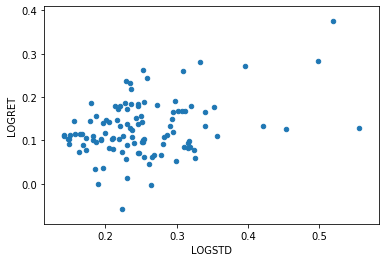

In [79]:
profiles['LOGRET'] = log_ret.mean().mul(365)
profiles['LOGSTD'] = log_ret.std().mul(np.sqrt(365))

profiles.plot(kind='scatter', x='LOGSTD', y='LOGRET')#, size='Beta')
plt.show()

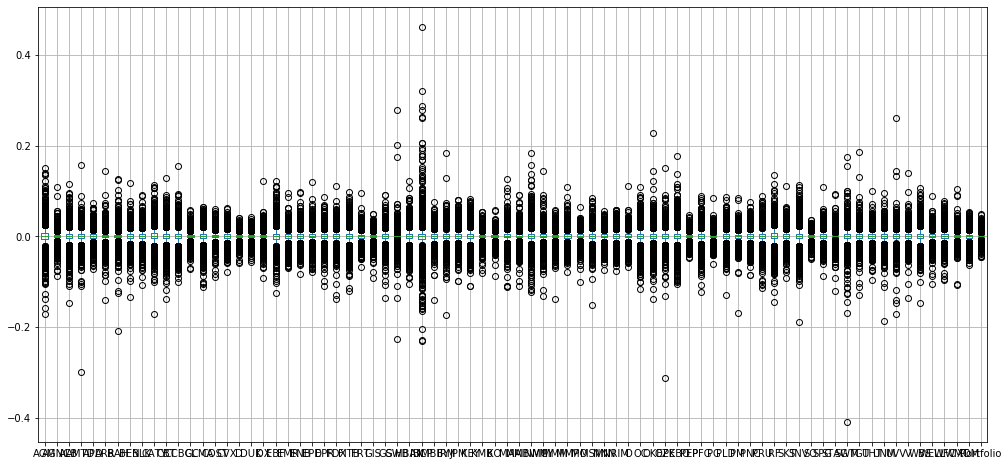

AGM: 16.2%, 14.94%, 1.08
AGNC: 13.37%, 12.6%, 1.06
ALB: 13.04%, 14.52%, 0.9
AMTD: 13.66%, 14.4%, 0.95
APD: 14.06%, 13.58%, 1.03
ARR: 10.69%, 12.84%, 0.83
BAH: 14.81%, 13.35%, 1.11
BEN: 11.62%, 14.32%, 0.81
BLK: 13.36%, 14.3%, 0.93
CATY: 14.68%, 14.69%, 1.0
CBT: 13.08%, 14.61%, 0.9
CCBG: 13.25%, 14.16%, 0.94
CL: 12.9%, 12.86%, 1.0
CMA: 13.49%, 14.18%, 0.95
COST: 14.77%, 13.07%, 1.13
CVX: 13.0%, 13.55%, 0.96
D: 13.58%, 12.63%, 1.08
DUK: 13.22%, 12.46%, 1.06
DX: 11.67%, 12.86%, 0.91
EBF: 13.1%, 14.28%, 0.92
EMR: 13.17%, 13.84%, 0.95
ENB: 13.5%, 13.31%, 1.01
EPD: 13.99%, 13.26%, 1.05
EPR: 13.89%, 13.39%, 1.04
FDX: 12.73%, 14.01%, 0.91
FITB: 13.92%, 14.35%, 0.97
FRT: 13.28%, 13.11%, 1.01
GIS: 12.97%, 12.72%, 1.02
GS: 12.46%, 14.13%, 0.88
GWB: 13.3%, 12.98%, 1.03
HBAN: 14.43%, 14.35%, 1.01
IBCP: 13.81%, 15.85%, 0.87
IMBBY: 12.64%, 13.22%, 0.96
IRM: 13.4%, 13.55%, 0.99
JPM: 14.07%, 14.09%, 1.0
KEY: 14.16%, 14.4%, 0.98
KMB: 13.59%, 12.81%, 1.06
KO: 13.38%, 12.75%, 1.05
MA: 16.05%, 14.23%, 1.13

In [80]:
log_ret[sel].boxplot(figsize=(17,8))
plt.show()

candidatesSeries = pd.Series(index=sel)
riskSeries = pd.Series(index=sel)
for n in sel:
    t = portfolio[:]
    t.append(n)
    
    mu = log_ret[t].mean(axis=1).mean()*365
    cov = log_ret[t].cov()
    w = np.ones(len(t))
    w /= np.sum(w)
    risk = np.sqrt(365 * np.dot(w.T, np.dot(cov, w)))

    riskSeries.loc[n] = risk
    candidatesSeries.loc[n] = mu/risk
    print('{}: {}%, {}%, {}'.format(n, round(100*mu,2), 
                                    round(100*risk,2), 
                                    round(mu/risk, 2)))

bestSH = candidatesSeries[candidatesSeries > candidatesSeries['Portfolio']]
bestSH = bestSH[bestSH > bestSH.quantile(0.75)].index.to_list()

lowestRisk = riskSeries[riskSeries < riskSeries['Portfolio']]
lowestRisk = lowestRisk[lowestRisk < lowestRisk.quantile(0.25)].index.to_list()

print('\nBased on Return/Risk ratio, best pick would be {}'.format(bestSH))
print('Based on lowest portfolio Risk, best pick would be {}'.format(lowestRisk))

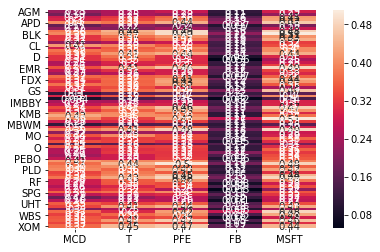

IBCP    0.171023
GWB     0.189472
MBWM    0.205646
NRIM    0.231587
ARR     0.253446
AGNC    0.258440
MMP     0.264230
EPD     0.287993
SO      0.293811
DX      0.295263
dtype: float64

Based on correlations, best picks would be:
['IBCP', 'GWB', 'MBWM', 'NRIM', 'ARR', 'AGNC', 'MMP', 'EPD', 'SO', 'DX', 'IMBBY', 'DUK', 'UVV', 'BAH', 'AGM', 'SWM', 'PEBO', 'TGT', 'WELL']


In [81]:
sns.heatmap(log_ret.corr(method='pearson').loc[selection.index, portfolio], annot=True)
plt.show()

bestPick = pd.Series(data=np.zeros(len(selection.index)), index=selection.index)

for b in bestPick.index:
    pear = pearsonr(log_ret['Portfolio'], log_ret[b])
    spear = spearmanr(log_ret['Portfolio'], log_ret[b])

    pSum = pear[1]+spear[1]
    if np.logical_and(pear[1]<0.05, spear[1]<0.05):
        bestPick.loc[b] = pear[0]*pear[1]/pSum + spear[0]*spear[1]/pSum
    elif pear[1]<0.05:
        bestPick.loc[b] = pear[0]
    elif spear[1]<0.05:
        bestPick.loc[b] = spear[0]

bestPick = bestPick.dropna()
bestCOR = bestPick[bestPick < bestPick.quantile(0.25)].sort_values().index.to_list()

print(bestPick.sort_values().head(10))
print('\nBased on correlations, best picks would be:\n{}'.format(bestCOR))

In [82]:
n = 100
simRet = pd.DataFrame(columns=sel, index=list(range(n)))
simRisk = pd.DataFrame(columns=sel, index=list(range(n)))

for asset in sel:
    simRet[asset] = 0.0
    simRisk[asset] = 0.0

    for i in range(n):
        mu = ret[asset].mean()
        sigma = ret[asset].std()
        
        simulations = (np.ones(n*365) * mu -(sigma**2)/2) + np.random.standard_normal(n*365) * sigma
        
        simRet.loc[i, asset] = np.mean(simulations) * 365
        simRisk.loc[i, asset] = np.std(simulations) * np.sqrt(365)


bestRisk = simRisk.mode().median().sort_values()
bestRisk = bestRisk[bestRisk < bestRisk.quantile(0.25)]

bestReturns = simRet.mode().median()
bestReturns = bestReturns[bestReturns>bestReturns.quantile(0.75)]

bestSharpe = bestReturns/bestRisk
bestSharpe = bestSharpe[bestSharpe > bestSharpe.quantile(0.75)].sort_values(ascending=False)

if 'Portfolio' in bestSharpe.index: bestSharpe = bestSharpe.drop('Portfolio')
if 'Portfolio' in bestRisk.index: bestRisk = bestRisk.drop('Portfolio')
if 'Portfolio' in bestReturns.index: bestReturns = bestReturns.drop('Portfolio')

bestReturns.sort_values(ascending=False)

MA      0.279131
BAH     0.278655
IBCP    0.277494
V       0.267873
JPM     0.212383
CCBG    0.211579
COST    0.195910
UHT     0.195509
APD     0.184907
AGM     0.180676
STAG    0.171717
PLD     0.169936
BLK     0.169099
AMTD    0.169004
MAIN    0.163972
RF      0.160632
MBWM    0.157280
KEY     0.157245
SNV     0.155933
dtype: float64

In [83]:
invetable = []

if len(bestSH)>=1:
    #print('\nBased on Return/Risk ratio, best picks would be:')
    for p in bestSH:
        #print(p)
        invetable.append(p)

if len(lowestRisk)>=1:
    #print('\nBased on Risk, best picks would be:')
    for p in lowestRisk:
        #print(p)
        invetable.append(p)

if len(bestCOR)>=1:
    #print('\nBased on correlations, best picks would be:')
    for p in bestCOR:
        #print(p)
        invetable.append(p)

if len(underVal)>=1:
    #print('\nBased on historical prices these stocks seam undervalued:')
    for p in underVal:
        #print(p)
        invetable.append(p)

try:
    if len(bestSharpe.index)>=1:
        #print('\nBased on simulated Return/Risk ratio, best picks would be:')        
        for p in bestSharpe.index.to_list():
            #print(p)
            invetable.append(p)

    if len(bestRisk.index):
        #print('\nBased on simulated Risk, best picks would be:')        
        for p in bestRisk.index.to_list():
            #print(p)
            invetable.append(p)

    if len(bestReturns.index)>=1:
        #print('\nBased on simulated Return, best picks would be:')        
        for p in bestReturns.index.to_list():
            #print(p)
            invetable.append(p)
except:
    print('\nNo simulations were made.')
    
invDF = pd.DataFrame(invetable).groupby(0)[0].count()
print('\nMost frequently picked assets:')
profiles.loc[invDF.sort_values(ascending=False)[invDF==invDF.max()].index]


Most frequently picked assets:


,Name,Industry,Sub-Industry,Beta,RET,STD,MoM,LOGRET,LOGSTD
0,,,,,,,,,
SO,The Southern Company,Utilities,Utilities—Regulated Electric,NaN,0.110218,0.122370,BUY,0.110476,0.142383
AGNC,AGNC Investment Corp.,Real Estate,REIT—Mortgage,NaN,0.104016,0.150436,BUY,0.101732,0.182826
MBWM,Mercantile Bank Corporation,Financial Services,Banks—Regional,NaN,0.308521,0.344083,BUY,0.280606,0.332967
BAH,Booz Allen Hamilton Holding Corporation,Industrials,Consulting Services,NaN,0.225515,0.244411,BUY,0.188104,0.253917
COST,Costco Wholesale Corporation,Consumer Defensive,Discount Stores,NaN,0.186447,0.160729,SELL,0.185329,0.179451
DUK,Duke Energy Corporation,Utilities,Utilities—Regulated Electric,NaN,0.095603,0.132675,HOLD,0.092755,0.148678


In [84]:
selection[selection['Beta'] <= selection['Beta'].quantile(0.25)].sort_values(by='Beta')

,Name,Industry,Sub-Industry,Beta,RET,STD,MoM


In [85]:
profiles[profiles['Beta'] <= profiles['Beta'].quantile(0.05)].sort_values(by='Beta')

,Name,Industry,Sub-Industry,Beta,RET,STD,MoM,LOGRET,LOGSTD
